In [13]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
c = 2.99792458e8   # m/s

In [46]:
def doppler(v):
    frac = (1. - v/c) / (1. + v/c)
    return np.sqrt(frac)

def gamma(v):
    return 1. / np.sqrt(1. - (v/c) ** 2)

def dlndopplerdv(v):
    dv = doppler(v)
    return -1. * gamma(v) / (2. * c) * (1. / dv  + dv)

def state(v, xs, xps):
    '''
    outputs: (M, Mp, v, xs, ms, mps, ehs, bees, seas)
    M and Mp are the lengths of data and model wavelength grids
    v is the RV
    xs is the wavelength values of the data grid
    ms is the data index m at which there is an interpolated model value
    mps is the model index m' from which we interpolate to ms
    ehs, bees, and seas go into the coefficients of interpolation
    '''
    # every input must be 1-d
    M = len(xs)
    Mp = len(xps)
    xps_shifted = xps + np.log(doppler(v))
    ms = np.arange(M)
    mps = np.searchsorted(xps_shifted, xs, side='left')
    good = (mps > 0) * (mps < Mp)
    ms = ms[good]
    mps = mps[good]
    ehs = xps_shifted[mps] - xs[ms]
    bees = xs[ms] - xps_shifted[mps - 1]
    seas = ehs + bees
    return (M, Mp, v, xs, ms, mps, ehs, bees, seas)

def Pdot(state, vec):
    # takes state and model flux vector, returns (shifted) model interpolated into data space
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(M)
    result[ms] = vec[mps - 1] * ehs / seas + vec[mps] * bees / seas
    return result

def dotP(state, vec):
    # takes state and data flux vector, returns data interpolated into (shifted) model space
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(Mp)
    result[mps - 1] += vec[ms] * ehs / seas
    result[mps] += vec[ms] * bees / seas
    return result

def dotdPdv(state, vec):
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(Mp)
    foos = vec[ms] / seas * dlndopplerdv(v) # * xs[ms] ??
    result[mps - 1] += foos
    result[mps] -= foos
    return result

def dPdotdv(state, vec):
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(M)
    result[ms] = (vec[mps - 1] - vec[mps]) * dlndopplerdv(v) / seas
    return result

The following is code copied from EPRV/fakedata.py to generate a realistic fake spectrum:

In [47]:
def oned_gaussian(xs, mm, sig):
    return np.exp(-0.5 * (xs - mm) ** 2 / sig ** 2) / np.sqrt(2. * np.pi * sig)

def make_synth(rv, xs, ds, ms, sigs):
    """
    `rv`: radial velocity in m/s (or same units as `c` above
    `xs`: `[M]` array of wavelength values
    `ds`: depths at line centers
    `ms`: locations of the line centers in rest wavelength
    `sigs`: Gaussian sigmas of lines
    """
    synths = np.ones_like(xs)
    for d, m, sig in zip(ds, ms, sigs):
        synths *= np.exp(d *
            oned_gaussian(xs * doppler(rv), m, sig))
    return synths

def make_data(N, xs, ds, ms, sigs):
    """
    `N`: number of spectra to make
    `xs`: `[M]` array of wavelength values
    `ds`: depth-like parameters for lines
    `ms`: locations of the line centers in rest wavelength
    `sigs`: Gaussian sigmas of lines
    """
    M = len(xs)
    data = np.zeros((N, M))
    ivars = np.zeros((N, M))
    rvs = 30000. * np.random.uniform(-1., 1., size=N) # 30 km/s bc Earth ; MAGIC
    for n, rv in enumerate(rvs):
        ivars[n, :] = 10000. # s/n = 100 ; MAGIC
        data[n, :] = make_synth(rv, xs, ds, ms, sigs)
        data[n, :] += np.random.normal(size=M) / np.sqrt(ivars[n, :])
    return data, ivars, rvs

In [48]:
fwhms = [0.1077, 0.1113, 0.1044, 0.1083, 0.1364, 0.1, 0.1281,
                    0.1212, 0.1292, 0.1526, 0.1575, 0.1879] # FWHM of Gaussian fit to line (A)
sigs = np.asarray(fwhms) / 2. / np.sqrt(2. * np.log(2.)) # Gaussian sigma (A)
ms = [4997.967, 4998.228, 4998.543, 4999.116, 4999.508, 5000.206, 5000.348,
                5000.734, 5000.991, 5001.229, 5001.483, 5001.87] # line center (A)
ds = [-0.113524, -0.533461, -0.030569, -0.351709, -0.792123, -0.234712, -0.610711,
                -0.123613, -0.421898, -0.072386, -0.147218, -0.757536] # depth of line center (normalized flux)
ws = np.ones_like(ds) # dimensionless weights
dx = 0.01 # A
xs = np.arange(4998. + 0.5 * dx, 5002., dx) # A
        
N = 16
data, ivars, true_rvs = make_data(N, xs, ds, ms, sigs)

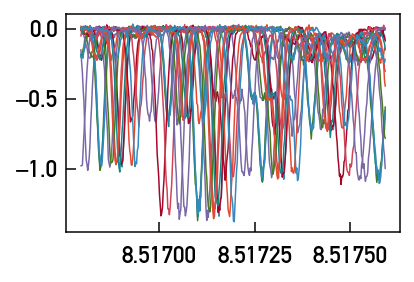

In [49]:
data = np.log(data)
data_xs = np.log(xs)
for i in range(N):
    plt.plot(data_xs, data[i])

Make a perfect model:

In [50]:
model_xs = np.arange(4996., 5004., dx)
model_ys = np.log(make_synth(0.0, model_xs, ds, ms, sigs))
model_xs = np.log(model_xs)

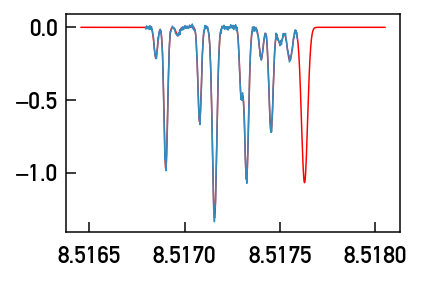

In [51]:
plt.plot(model_xs + np.log(doppler(-true_rvs[0])), model_ys, color='red')
plt.plot(data_xs, data[0,:])

Test that we can optimize to the correct RV:

In [52]:
test_rvs = np.arange(- true_rvs[0] - 1000, - true_rvs[0] + 1000, 20.)
chisq = np.zeros_like(test_rvs)
for i,v in enumerate(test_rvs):
    s = state(v, data_xs, model_xs)
    pd = Pdot(s, model_ys)
    chisq[i] = np.sum((data[0,:] - pd)**2 * ivars[0,:])

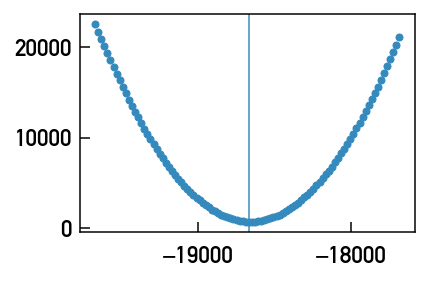

In [53]:
plt.scatter(test_rvs, chisq)
plt.axvline(-true_rvs[0])
#plt.xlim([23300,23500])
#plt.ylim([7000,7500])

In [54]:
print -true_rvs

[-18666.06278996   7935.48245143 -18512.31427507  -1933.02597176
 -14884.55301223  -2234.8122564  -26450.18301567  -2482.7242951
  -9426.48471357  26937.70039147 -10864.49657242  20824.90272234
 -17092.48755468 -14160.65441083 -29865.99646942  12898.96934511]


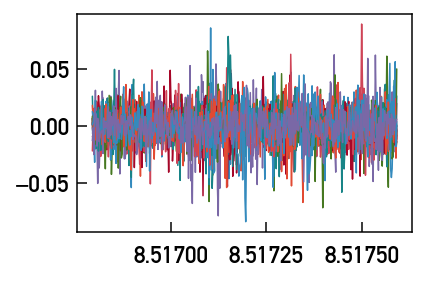

In [57]:
for i in range(N):
    s = state(-true_rvs[i], data_xs, model_xs)
    pd = Pdot(s, model_ys)
    plt.plot(data_xs, data[i,:] - pd)
    #plt.plot(data_xs, data[i,:])
    #plt.plot(data_xs, pd)

Test that an optimizer can do it:

In [58]:
def chisq(rvs, data_xs, data, ivars, model_xs, model_ys):
    N = len(rvs)
    chisq = 0.
    for n in range(N):
        s = state(rvs[n], data_xs, model_xs)
        pd = Pdot(s, model_ys)
        chisq += np.sum((data[n,:] - pd)**2 * ivars[n,:])
    return chisq #np.sum((data - pd)**2 * ivars)

In [59]:
from scipy.optimize import fmin_cg

In [63]:
x0 = - true_rvs + np.random.normal(0., 100., N)

soln =  fmin_cg(chisq, x0, args=(data_xs, data, ivars, model_xs, model_ys), gtol=1.e-8, epsilon=1.5e-5)

#print chisq(x0, data_xs, data, ivars, model_xs, model_ys)
#print chisq(true_rvs, data_xs, data, ivars, model_xs, model_ys)

         Current function value: 12734.679131
         Iterations: 10
         Function evaluations: 1073
         Gradient evaluations: 59


In [65]:
soln[0] + true_rvs[0]

8.9367039174758247

In [66]:
print soln + true_rvs

print soln - x0

[  8.93670392  29.61244704  -6.57653205 -17.96995702  -7.34569976
 -12.59762373  10.37237098  10.52085613 -13.99253592   2.10276834
  -0.53945944  10.98491913   5.31813964 -11.2062331   15.72185818
 -16.54615978]
[ -56.77086292   21.57201026  -64.42843947  -23.32714581   85.1568275
   11.37529088 -154.83337429   82.89380467   91.80218825   17.60492612
  -89.72472093   15.04164166 -103.903631    -30.11572215   -0.90018593
  -61.77146557]


In [68]:
np.std(soln + true_rvs)

13.102876407927035

Let's add a tellurics model component!

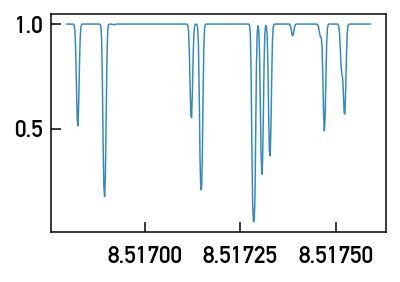

In [19]:
def add_tellurics(xs, all_data, true_rvs, lambdas, strengths, dx):
    N, M = np.shape(all_data)
    tellurics = np.ones_like(xs)
    for ll, s in zip(lambdas, strengths):
        tellurics *= np.exp(-s * oned_gaussian(xs, ll, dx))
    plt.plot(xs, tellurics)
    all_data *= np.repeat([tellurics,],N,axis=0)
    return all_data

n_tellurics = 16 # magic
telluric_sig = 3.e-6 # magic
telluric_xs = np.random.uniform(data_xs[0], data_xs[-1], n_tellurics)
strengths = 0.01 * np.random.uniform(size = n_tellurics) ** 2. # magic numbers
all_data = np.exp(data)
all_data = add_tellurics(data_xs, all_data, true_rvs, telluric_xs, strengths, telluric_sig)
data = np.log(all_data)


In [20]:
model_xs_star = data_xs
model_ys_star = np.log(make_synth(0.0, xs, ds, ms, sigs))
model_xs_t = data_xs
tellurics_model = np.ones_like(data_xs)
for ll, s in zip(telluric_xs, strengths):
    tellurics_model *= np.exp(-s * oned_gaussian(data_xs, ll, telluric_sig))
model_ys_t = np.log(tellurics_model)

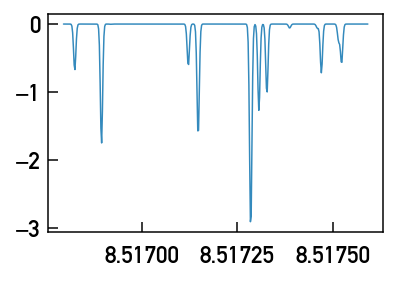

In [21]:
plt.plot(data_xs, np.log(tellurics_model))

array([[ 0.98670303,  0.99180462,  1.00278651, ...,  0.93073869,
         0.95037611,  0.93664913],
       [ 1.01857791,  0.98537312,  0.98832055, ...,  0.96280376,
         0.96001786,  0.97261974],
       [ 0.68138164,  0.60339476,  0.53072917, ...,  0.98868854,
         0.99056023,  0.99370428],
       ..., 
       [ 0.9504023 ,  0.93664905,  0.93421876, ...,  0.36389323,
         0.35904705,  0.34656282],
       [ 0.99292254,  0.99453396,  0.98603833, ...,  0.99398087,
         1.00670142,  1.00262261],
       [ 0.72377709,  0.64202366,  0.55447768, ...,  0.97588598,
         0.98878625,  1.0107531 ]])

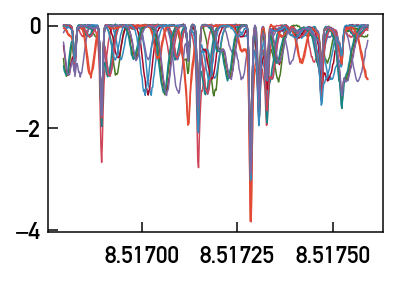

In [22]:
for i in range(N):
    plt.plot(data_xs, data[i,:])
all_data

Solve iteratively for star RVs and telluric RVs:

In [23]:
def chisq_star(rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    pd_star = Pdot(data_xs, model_xs_star, model_ys_star, rvs_star)
    pd_t = Pdot(data_xs, model_xs_t, model_ys_t, rvs_t)
    pd = pd_star + pd_t
    return np.sum((data - pd)**2 * ivars)

def chisq_t(rvs_t, rvs_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    pd_star = Pdot(data_xs, model_xs_star, model_ys_star, rvs_star)
    pd_t = Pdot(data_xs, model_xs_t, model_ys_t, rvs_t)
    pd = pd_star + pd_t
    return np.sum((data - pd)**2 * ivars)

x0_star = true_rvs + np.random.normal(0., 100., N)
x0_t = np.zeros(N)
soln_star =  fmin_cg(chisq_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     gtol=1.e-8, epsilon=1.5e-5)
soln_t =  fmin_cg(chisq_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     gtol=1.e-8, epsilon=1.5e-5)


         Current function value: 196825.853690
         Iterations: 37
         Function evaluations: 2605
         Gradient evaluations: 144
         Current function value: 196773.015250
         Iterations: 16
         Function evaluations: 1434
         Gradient evaluations: 79


In [24]:
print soln_star - true_rvs

print soln_star - x0_star

print np.std(soln_star - true_rvs)

[ -7.79161156  18.61193497  11.40654726  22.40171635  -5.04340025
  23.23933508   8.88985428  -7.44351544 -23.11558975  32.82592279
  11.52421668  19.32323191  15.76532786  -2.24588044   2.61992231
   4.8802171 ]
[ -36.82523782  129.53348243  -97.58624246   18.56455128   -8.21864551
    6.09556629  -13.5799874  -147.28688861  -81.45060728  -44.96411549
   77.30304914  116.21972106   56.47292544  -59.80736688  103.48715205
   -5.99851569]
14.0344957267


In [25]:
print soln_t
print np.std(soln_t)

[  3.89179587e+00   1.15220119e+00  -2.28693562e+00   4.71425843e+00
   2.05810651e-01   1.63862997e+00   1.55554757e+00  -7.67846548e+00
   1.04064871e-01  -6.51277080e+00   5.21182202e-01   3.55850250e-01
  -2.79854343e-03   3.81598864e+00  -3.72086597e+00  -3.77956618e-01]
3.34456867087


In [26]:
pd_star = Pdot(data_xs, model_xs_star, model_ys_star, soln_star)
pd_t = Pdot(data_xs, model_xs_t, model_ys_t, soln_t)
pd = pd_star + pd_t

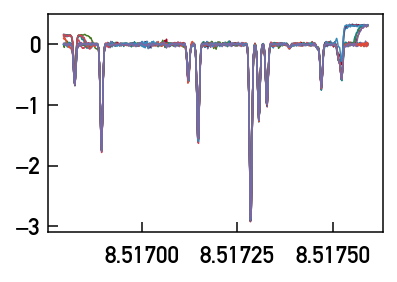

In [27]:
for i in range(N):
    plt.plot(data_xs, data[i,:] - pd_star[i,:])

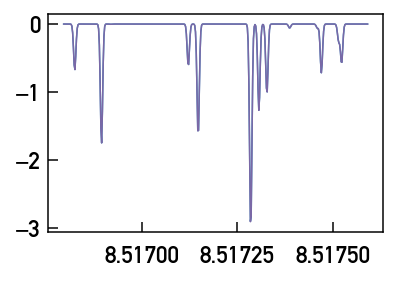

In [28]:
plt.plot(data_xs, pd_t[0,:])
plt.plot(data_xs, model_ys_t)

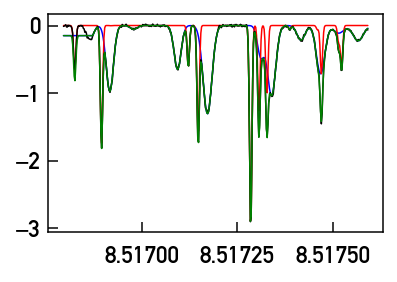

In [29]:
plt.plot(data_xs, pd_star[0,:], color='blue')
plt.plot(data_xs, pd_t[0,:], color='red')

plt.plot(data_xs, data[0,:], color='k')

plt.plot(data_xs, pd[0,:], color='green')

Build a model from the data rather than being cheaty cheaters who cheat:

In [30]:
def make_template(all_data, rvs, xs, dx):
    """
    `all_data`: `[N, M]` array of pixels
    `rvs`: `[N]` array of RVs
    `xs`: `[M]` array of wavelength values
    `dx`: linear spacing desired for template wavelength grid (A)
    """
    (N,M) = np.shape(all_data)
    all_xs = np.empty_like(all_data)
    for i in range(N):
        all_xs[i,:] = xs + np.log(doppler(rvs[i])) # shift to rest frame
    all_data, all_xs = np.ravel(all_data), np.ravel(all_xs)
    tiny = 10.
    template_xs = np.arange(min(all_xs)-tiny*dx, max(all_xs)+tiny*dx, dx)
    template_ys = np.nan + np.zeros_like(template_xs)
    for i,t in enumerate(template_xs):
        ind = (all_xs >= t-dx/2.) & (all_xs < t+dx/2.)
        if np.sum(ind) > 0:
            #template_ys[i] = np.sum(all_data[ind]) / np.sum(ind)
            template_ys[i] = np.nanmedian(all_data[ind])
    ind_nan = np.isnan(template_ys)
    template_ys[ind_nan] = np.interp(template_xs[ind_nan], template_xs[~ind_nan], template_ys[~ind_nan])
    return template_xs, template_ys

In [40]:
def subtract_template(data_xs, data, model_xs_t, model_ys_t, rvs_t):
    (N,M) = np.shape(data)
    data_sub = np.copy(data)
    for n,v in enumerate(rvs_t):
        #model_xs_t_shifted = model_xs_t  + np.log(doppler(v)) # shift to rest frame
        model_ys_t_shifted = Pdot(data_xs, model_xs_t, model_ys_t, v)
        data_sub[n,:] -= np.ravel(model_ys_t_shifted)
    return data_sub

In [41]:
x0_star = true_rvs + np.random.normal(0., 100., N)
x0_t = np.zeros(N)
model_xs_star, model_ys_star = make_template(data, x0_star, data_xs, np.log(6000.01) - np.log(6000.))
model_xs_t, model_ys_t = make_template(data, x0_t, data_xs, np.log(6000.01) - np.log(6000.))

[]


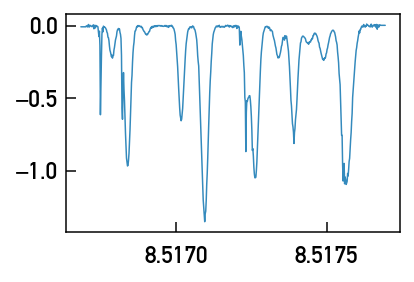

In [42]:
plt.plot(model_xs_star, model_ys_star)
print model_ys_star[np.where(np.isnan(model_ys_star))]

[]


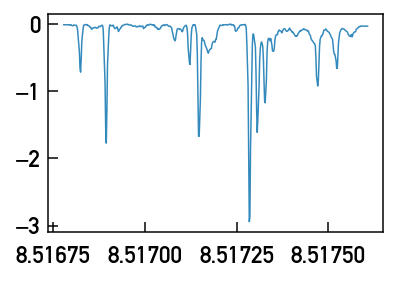

In [43]:
plt.plot(model_xs_t, model_ys_t)
print model_ys_t[np.where(np.isnan(model_ys_t))]

In [44]:
x0_t = np.zeros(N)
soln_star =  fmin_cg(chisq_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     gtol=1.e-8, epsilon=1.5e-5)
soln_t =  fmin_cg(chisq_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     gtol=1.e-8, epsilon=1.5e-5)

         Current function value: 1507179.463825
         Iterations: 31
         Function evaluations: 2694
         Gradient evaluations: 149
         Current function value: 1500810.355053
         Iterations: 21
         Function evaluations: 2011
         Gradient evaluations: 111


In [45]:
def chisq_star(rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    pd_star = Pdot(data_xs, model_xs_star, model_ys_star, rvs_star)
    pd_t = Pdot(data_xs, model_xs_t, model_ys_t, rvs_t)
    pd = pd_star + pd_t
    return np.sum((data - pd)**2 * ivars)

chisq_star(x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)

1532393.0116287433

In [46]:
print np.std(soln_star - true_rvs)
print np.std(soln_t)
pd_star = Pdot(data_xs, model_xs_star, model_ys_star, soln_star)
pd_t = Pdot(data_xs, model_xs_t, model_ys_t, soln_t)
pd = pd_star + pd_t

258.282123466
29.5281104307


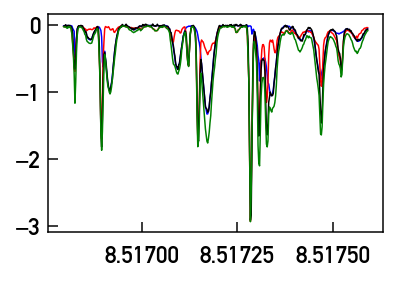

In [47]:
plt.plot(data_xs, pd_star[0,:], color='blue')
plt.plot(data_xs, pd_t[0,:], color='red')

plt.plot(data_xs, data[0,:], color='k')

plt.plot(data_xs, pd[0,:], color='green')

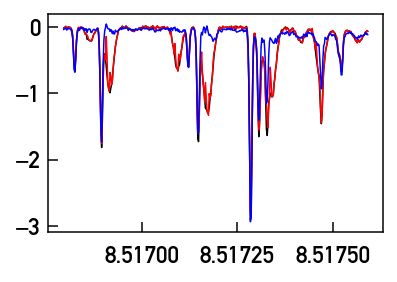

In [52]:
data_star = subtract_template(data_xs, data, model_xs_t, model_ys_t, soln_t)
data_t = subtract_template(data_xs, data, model_xs_star, model_ys_star, soln_star)

plt.plot(data_xs, data[0,:], color='k')
plt.plot(data_xs, data_star[0,:], color='red')
plt.plot(data_xs, data_t[0,:], color='blue')

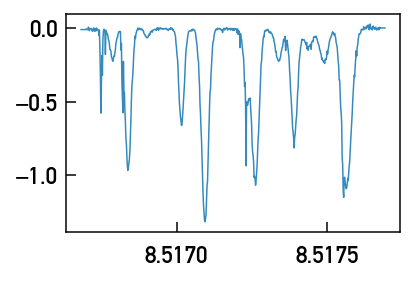

In [53]:
x0_star = soln_star
x0_t = soln_t

model_xs_star, model_ys_star = make_template(data_star, x0_star, data_xs, np.log(6000.01) - np.log(6000.))
plt.plot(model_xs_star, model_ys_star)

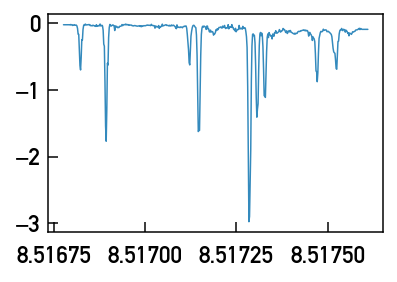

In [54]:
model_xs_t, model_ys_t = make_template(data_t, x0_t, data_xs, np.log(6000.01) - np.log(6000.))
plt.plot(model_xs_t, model_ys_t)

In [55]:
soln_star =  fmin_cg(chisq_star, x0_star, args=(x0_t, data_xs, data_star, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     gtol=1.e-8, epsilon=1.5e-5)
soln_t =  fmin_cg(chisq_t, x0_t, args=(soln_star, data_xs, data_t, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     gtol=1.e-8, epsilon=1.5e-5)

print np.std(soln_star - true_rvs)
print np.std(soln_t)

         Current function value: 1336539.722776
         Iterations: 20
         Function evaluations: 1434
         Gradient evaluations: 79
         Current function value: 9069170.141574
         Iterations: 66
         Function evaluations: 4592
         Gradient evaluations: 254
182.286838375
37.8229308707


In [56]:
for n in range(5):
    x0_star = soln_star
    x0_t = soln_t

    data_star = subtract_template(data_xs, data, model_xs_t, model_ys_t, x0_t)
    data_t = subtract_template(data_xs, data, model_xs_star, model_ys_star, x0_star)

    model_xs_star, model_ys_star = make_template(data_star, x0_star, data_xs, np.log(6000.01) - np.log(6000.))
    model_xs_t, model_ys_t = make_template(data_t, x0_t, data_xs, np.log(6000.01) - np.log(6000.))

    soln_star =  fmin_cg(chisq_star, x0_star, args=(x0_t, data_xs, data_star, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     gtol=1.e-8, epsilon=1.5e-5)
    soln_t =  fmin_cg(chisq_t, x0_t, args=(soln_star, data_xs, data_t, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     gtol=1.e-8, epsilon=1.5e-5)

    print "iter {0}: star std = {1:.2f}, telluric std = {2:.2f}".format(n, np.std(soln_star - true_rvs), np.std(soln_t))


         Current function value: 7607120.752594
         Iterations: 13
         Function evaluations: 1253
         Gradient evaluations: 69
         Current function value: 7385156.613574
         Iterations: 45
         Function evaluations: 3054
         Gradient evaluations: 169
iter 0: star std = 440.86, telluric std = 30.57
         Current function value: 9294384.900168
         Iterations: 74
         Function evaluations: 4420
         Gradient evaluations: 245
         Current function value: 9314501.062018
         Iterations: 29
         Function evaluations: 2436
         Gradient evaluations: 135
iter 1: star std = 520.72, telluric std = 17.49
         Current function value: 7904536.796498
         Iterations: 10
         Function evaluations: 1020
         Gradient evaluations: 56
         Current function value: 7541081.556182
         Iterations: 14
         Function evaluations: 1240
         Gradient evaluations: 68
iter 2: star std = 620.99, telluric std = 20.47
 